Cheapest path: [13, 26, 10, 15, 3, 1, 23, 14, 9, 20, 25, 12, 6, 27, 16, 5, 19, 21, 4, 8, 7, 22, 17, 18, 24, 11, 2, 13]
Cheapest path length: 816.5973753624091


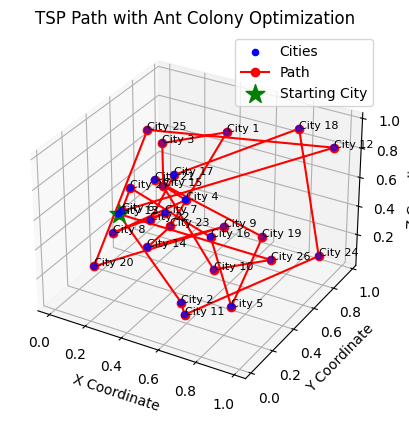

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def cost(point1, point2):
    return distance(point1, point2) + 100 * np.random.rand()

def is_valid_time_window(visited, current_city, time_windows):
    current_time = visited[current_city][1]
    return time_windows[current_city][0] <= current_time <= time_windows[current_city][1]

def utility_based_agent(points, pheromone, alpha, beta, time_windows):
    visited = [[False, 0] for _ in range(len(points))]  # [Visited?, Arrival time]
    current_point = np.random.randint(len(points))
    visited[current_point][0] = True
    path = [current_point + 1]  # Add 1 to the city number to adjust for starting from 1
    path_length = 0

    while False in [v[0] for v in visited]:
        unvisited = np.where(np.logical_not([v[0] for v in visited]))[0]
        probabilities = np.zeros(len(unvisited))

        for i, unvisited_point in enumerate(unvisited):
            penalties = 0
            if points[current_point][1] > points[unvisited_point][1]:
                penalties += 100
            if points[current_point][1] < points[unvisited_point][1]:
                penalties -= 100
            if penalties < 0:
                penalties = 0

            if is_valid_time_window(visited, unvisited_point, time_windows):
                probabilities[i] = pheromone[current_point, unvisited_point]**alpha / cost(points[current_point], points[unvisited_point])**beta + penalties

        if np.sum(probabilities) == 0:
            # If no valid time window, allow visiting any city (non-time window constraint)
            probabilities = np.ones(len(unvisited))

        probabilities /= np.sum(probabilities)

        next_point = np.random.choice(unvisited, p=probabilities)
        arrival_time = max(visited[current_point][1] + cost(points[current_point], points[next_point]), time_windows[next_point][0])
        path.append(next_point + 1)  # Add 1 to the city number to adjust for starting from 1
        path_length += cost(points[current_point], points[next_point])
        visited[next_point][0] = True
        visited[next_point][1] = arrival_time
        current_point = next_point

    return path, path_length

def ant_colony_optimization(points, n_ants, n_iterations, alpha, beta, evaporation_rate, Q, time_windows):
    n_points = len(points)
    pheromone = np.ones((n_points, n_points))
    best_path = None
    best_path_length = np.inf

    for iteration in range(n_iterations):
        paths = []
        path_lengths = []

        for ant in range(n_ants):
            path, path_length = utility_based_agent(points, pheromone, alpha, beta, time_windows)
            paths.append(path)
            path_lengths.append(path_length)

            if path_length < best_path_length:
                best_path = path
                best_path_length = path_length

        pheromone *= evaporation_rate

        for path, path_length in zip(paths, path_lengths):
            for i in range(n_points - 1):
                pheromone[path[i] - 1, path[i + 1] - 1] += Q / path_length  # Subtract 1 to adjust for starting from 1
            pheromone[path[-1] - 1, path[0] - 1] += Q / path_length  # Subtract 1 to adjust for starting from 1

        # Dynamic pheromone update based on best path length found so far
        if iteration % 10 == 0:  # Adjust evaporation rate every 10 iterations (can be adjusted as needed)
            best_path_length_so_far = min(path_lengths)
            evaporation_rate = 0.5 * (1 - (best_path_length_so_far / best_path_length))  # Example adjustment formula

        #print(f"Iteration {iteration+1} - Pheromone Matrix:")
        #print(pheromone) -- gives output for the pheromone level at each

    # Ensure the best path ends with the same city as the first visited city
    best_path.append(best_path[0])

    return best_path, best_path_length

if __name__ == "__main__":
    np.random.seed(42)
    points = np.random.rand(27, 3)

    # Generate random time windows for each city (start time, end time)
    time_windows = np.random.randint(0, 100, size=(len(points), 2))

    best_path, best_path_length = ant_colony_optimization(points, n_ants=30, n_iterations=100, alpha=1, beta=1, evaporation_rate=0.5, Q=1, time_windows=time_windows)

    print("Cheapest path:", best_path)
    print("Cheapest path length:", best_path_length)
    # Extract x, y, and z coordinates of all cities
    x_coords = points[:, 0]
    y_coords = points[:, 1]
    z_coords = points[:, 2]

    # Plot all cities in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Cities')

    # Plot the path taken by the algorithm in 3D
    path_x = x_coords[np.array(best_path) - 1]
    path_y = y_coords[np.array(best_path) - 1]
    path_z = z_coords[np.array(best_path) - 1]
    ax.plot(path_x, path_y, path_z, c='r', marker='o', label='Path', linestyle='-')

    # Plot the starting city as a green star
    start_city_x, start_city_y, start_city_z = x_coords[best_path[0] - 1], y_coords[best_path[0] - 1], z_coords[best_path[0] - 1]
    ax.scatter(start_city_x, start_city_y, start_city_z, c='g', marker='*', s=200, label='Starting City')

    # Add city labels
    for i, (x, y, z) in enumerate(zip(x_coords, y_coords, z_coords)):
        ax.text(x, y, z, f'City {i + 1}', color='black', fontsize=8)

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title('TSP Path with Ant Colony Optimization')
    plt.legend()
    plt.grid(True)
    plt.show()
